In [98]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from ast import literal_eval
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image, display
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from gensim.models import Word2Vec


ruta = "C:/Users/Lenovo/OneDrive/Desktop/python/RS_chicago_restaurants/entree_data/entree/session"

def pos_nesima(cadena, caracter, n):
    
    if n == 1:
        return cadena.find(caracter)
    
    else:
        return cadena.find(caracter, pos_nesima(cadena, caracter, n - 1) + 1)

df_final = pd.DataFrame()
archivos_exp = [archivo for archivo in os.listdir(ruta) if archivo.endswith('.txt')]
for archivo in archivos_exp:
    with open(os.path.join(ruta, archivo)) as file:
        for line in file:
            idx = pos_nesima(line, '\t', 3)
            line = line[0 : (idx + 1)] + str(line[(idx + 1):(len(line)-1)].split('\t'))
            df_temporal = pd.DataFrame([line.split('\t')])
            df_final = pd.concat([df_final, df_temporal])





In [102]:
#### Formato
# date, ip, entry_point, rate_1, ... , rate_i, ..., rate_n, end_point

df_final.rename(columns = {0: 'date',
                 1: 'ip',
                 2: 'entry_point',
                 3: 'rated_i'}, inplace = True)
print('Primeras 5 filas:')
print(df_final.head())
print('\n' + 'Dimensiones del data frame:')
print(df_final.shape)
#df2 = df_final
#nuevo_indice = [i for i in df_final.date]
#df_final.drop('date', axis=1, inplace=True)
#df_final.index = pd.Index(nuevo_indice)
nuevo_indice = [i for i in range(0, len(df_final))]
df_final.index = pd.Index(nuevo_indice)
df_final



Primeras 5 filas:
                    date                        ip entry_point  \
0  07/Sep/1996:12:17:05      www-c09.proxy.gnn.com           0   
1  07/Sep/1996:12:21:57            foley.ripco.com           0   
2  07/Sep/1996:12:23:36            foley.ripco.com           0   
3  07/Sep/1996:12:25:14            foley.ripco.com           0   
4  07/Sep/1996:15:18:38   pslip103d.egr-ri.ids.net           0   

                                   rated_i  
0                  ['560L', '110L', '110']  
1                    ['423L', '77L', '77']  
2  ['633N', '633N', '159P', '159P', '475']  
3                  ['441L', '537L', '537']  
4     ['90M', '90M', '76L', '476L', '476']  

Dimensiones del data frame:
(50672, 4)


In [103]:
ruta_2 = "C:/Users/Lenovo/OneDrive/Desktop/python/RS_chicago_restaurants/entree_data/entree/data"
ruta_3 = "C:/Users/Lenovo/OneDrive/Desktop/python/RS_chicago_restaurants/entree_data/entree/data/features.txt"

archivos_rest = [archivo for archivo in os.listdir(ruta_2) if archivo != 'features.txt']

df_restaurants = pd.DataFrame()
df_features = pd.DataFrame()

id_rest = 0
for archivo in archivos_rest:
    
    with open(os.path.join(ruta_2, archivo)) as my_file:
        for line in my_file:
            
            idx = pos_nesima(line, '\t', 2)
            line = line[0 : (idx + 1)] + str(line[(idx + 1):(len(line)-1)].split(' ')) + f"\t {id_rest}"
            df_temporal = pd.DataFrame([line.split('\t')])
            df_restaurants = pd.concat([df_restaurants, df_temporal])
        
        id_rest += 1

with open(ruta_3) as my_file:
    for line in my_file:
        idx = pos_nesima(line, '\t', 1)
        line = line[0 : (idx + 1)] + str(line[(idx + 1): (len(line)-1)])
        df_temporal = pd.DataFrame([line.split('\t')])
        df_features = pd.concat([df_features, df_temporal])


In [104]:
df_restaurants.rename(columns= {0: 'id',
                                1: 'restaurant_name',
                                2: 'features',
                                3: 'id_city'},
                                inplace = True)

df_features.rename(columns = {0: 'id',
                              1: 'nombre_característica'},
                              inplace = True)

#print('Restaurants:')
#print(df_restaurants.head())
#print('\n Tabla características:')
#print(df_features.head())


df_restaurants['features'] = df_restaurants['features'].apply(literal_eval)


lista_caracteristicas = df_features['id'].to_numpy()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([lista_caracteristicas])

n_features = df_features.shape[0]
def OHE_personalizado(serie):

    vector_zeros = np.empty(n_features, dtype = 'object')

    for elem in serie:
        idx = int(elem)
        vector_zeros[idx] = elem
    one_hot_results = enc.transform([vector_zeros]).toarray()

    return one_hot_results[0]

df_restaurants['OHE_features'] = df_restaurants['features'].apply(OHE_personalizado)



### Esquema bdd

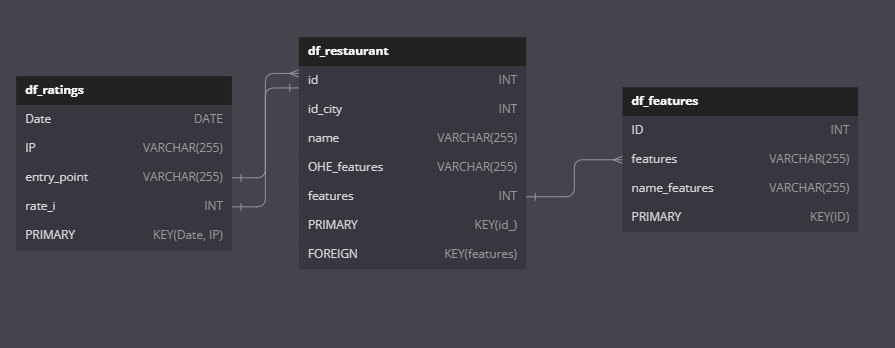

In [7]:
imagen_path = 'C:/Users/Lenovo/OneDrive/Desktop/python/RS_chicago_restaurants/entree_data/entree/esquema_basico.png'

display(Image(filename=imagen_path))

In [105]:
ohe_df = pd.DataFrame(df_restaurants['OHE_features'].tolist(), columns=[f'feature_{i}' for i in range(len(df_restaurants['OHE_features'].iloc[0]))])
df = df_restaurants.reset_index(drop = True)
restaurant_ohe = pd.concat([df[['id', 'id_city']], ohe_df], axis=1)

# Convertir la columna 'id' a tipo int
restaurant_ohe['id'] = restaurant_ohe['id'].astype(str)

restaurant_ohe['id'] = list(map(lambda x: x[-5:].replace(' ',''), restaurant_ohe['id'] + restaurant_ohe['id_city']))
selected_rows = restaurant_ohe.columns != 'id_city'
restaurant_ohe = restaurant_ohe.loc[:, selected_rows]


t_rest_values = restaurant_ohe.values[:, 1::].astype(float)
matriz_dispersa_rest = csr_matrix(t_rest_values)
knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_model.fit(matriz_dispersa_rest)


NearestNeighbors(algorithm='brute', metric='cosine')

### Proceso de recomendación basado en Contenido

* Aquí se consideran los 6 vecinos más cercanos para cada restaurant en la DB, acorde a las distancias cosenos obtenidas en el ítem anterior al ajustar el modelo

* Almacenamos las recomendaciones en un diccionario de la forma:
  {id_restaurant: (indice recomendado, distancia coseno respecto al local)},
  tal que id_restaurant se compone de 'id' concatenado con 'id_city'



In [106]:
# Almacenamos el diccionario de la forma {id_restaurant: (indice recomendado, distancia coseno respecto al local)}
# id_restaurant se compone de 'id' concatenado con 'id_city'

recomendados_cbp = {}
for fila in range(0, restaurant_ohe.shape[0]):

    dists, indxs = knn_model.kneighbors(restaurant_ohe.iloc[fila, 1::].values.reshape(1, -1), n_neighbors = 6)
    recomendados_cbp[restaurant_ohe.loc[fila, 'id']] = (indxs, dists)


### Proceso de recomendación Colaborativo (Usuarios)

In [107]:
def contar_ocurrencias(row):
    vector = np.zeros(676)
    for num in row:
        if num[-1].isnumeric():
            num = int(num)
            
        else:
            hasta = len(num) - 1
            num = int(num[0:hasta])
        vector[num] += 1
    return vector

def convert_num(row):
    vec = list(range(len(row)))
    cont = 0
    for num in row:
        if num[-1].isnumeric():
            num = int(num)
            
        else:
            hasta = len(num) - 1
            num = int(num[0:hasta])
        vec[cont] = num
        cont += 1
    return vec


df_final['rated_i'] = df_final['rated_i'].apply(literal_eval)
df_final['count_visits'] = df_final['rated_i'].apply(contar_ocurrencias).tolist()
df_final['rated_i2'] = df_final.iloc[:,3].apply(convert_num).tolist()
print(df_final.head())

                    date                        ip entry_point  \
0  07/Sep/1996:12:17:05      www-c09.proxy.gnn.com           0   
1  07/Sep/1996:12:21:57            foley.ripco.com           0   
2  07/Sep/1996:12:23:36            foley.ripco.com           0   
3  07/Sep/1996:12:25:14            foley.ripco.com           0   
4  07/Sep/1996:15:18:38   pslip103d.egr-ri.ids.net           0   

                         rated_i  \
0              [560L, 110L, 110]   
1                [423L, 77L, 77]   
2  [633N, 633N, 159P, 159P, 475]   
3              [441L, 537L, 537]   
4     [90M, 90M, 76L, 476L, 476]   

                                        count_visits  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                    rated_i2  
0            [560,

### Clusterings por batch

Con el fin de hacer escalable el método de recomendación, se realizará el proceso Colaborativo de usuarios mediante clustering.

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\U

Text(0, 0.5, 'inertia metric')

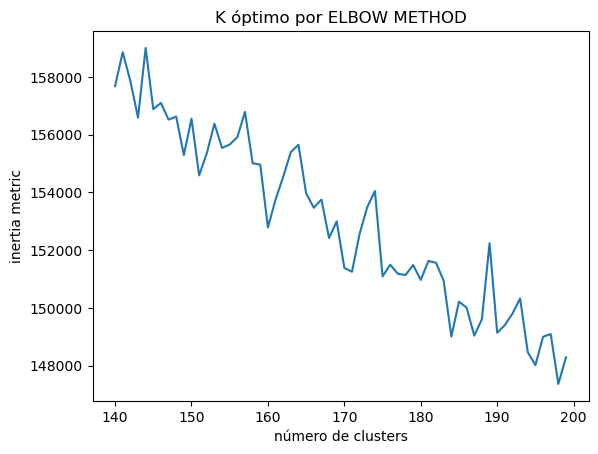

In [108]:
batch_size = 1024
k_listeds = []
for i in range(140, 200):
    kmeans = MiniBatchKMeans(init = 'k-means++', n_clusters=i,
                             batch_size=batch_size, n_init=10,
                             max_no_improvement=10, verbose=0)
    kmeans.fit(X)
    k_listeds.append(kmeans.inertia_)

plt.plot(range(140, 200), k_listeds)
plt.title('K óptimo por ELBOW METHOD')
plt.xlabel('número de clusters')
plt.ylabel('inertia metric')

Existen diversos métodos para escoger el "K" óptimo de número de clusters, dos eurísticas recomendadas son:
* El método del codo, que se basa en la disminución de la métrica de inercia (medida de error ponderada dentro de los clusters)
* $K = \sqrt{\dfrac{n}{2}}$ ; donde n sea el número de usuarios (en nuestro caso, unos 158 clusters)

Además de ello, se puede entrar más en detalle para comparar la velocidad de ejecución y la precisión con el fin de revisar cuál de las dos nos ofrece un mejor trade-off entre dichas características, que son las que se buscan optimizar.

In [109]:
k = 200
batch_size = 1024

mbk = MiniBatchKMeans(init = 'k-means++', n_clusters = k,
                      batch_size = batch_size, n_init = 10,
                      max_no_improvement = 10, verbose = 0)

data_visitas = df_final['count_visits']
X = np.vstack(data_visitas)
X = np.nan_to_num(X)

mbk.fit(X)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


### DISCLAIMER:
<span style="font-size:larger; color:red;"> EL SIGUIENTE PLOT ES SOLO CON EL FIN DE VISUALIZAR PARA VER QUÉ TANTO SE SEPARAN LOS CLUSTERS.</span>


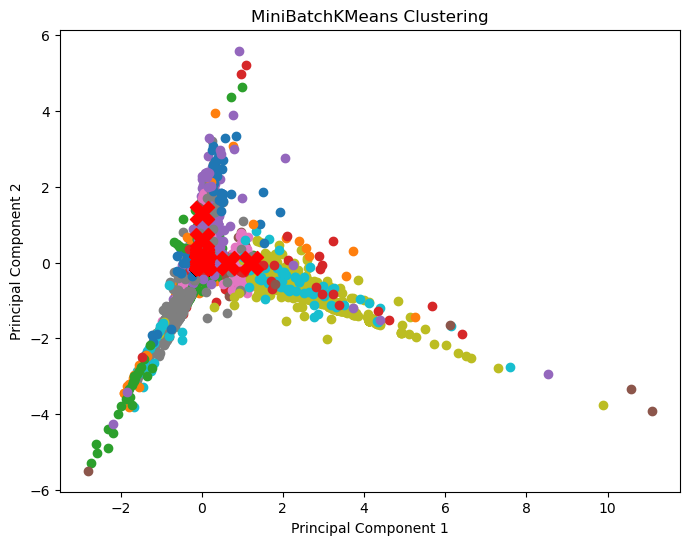

In [110]:
### FALTA CALCULAR CORRELACIONES PARA INTERPRETAR 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(X_pca[mbk_means_labels == i, 0], X_pca[mbk_means_labels == i, 1], label=f'Cluster {i}')

plt.scatter(mbk.cluster_centers_[:, 0], mbk.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('MiniBatchKMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [111]:
labels_x = mbk.labels_
distancias_por_cluster = {}

df_batches = pd.DataFrame(X)
df_batches['labels_x'] = labels_x
#print(df_batches.loc[df_batches['labels_x'] == label,df_batches.columns != 'labels_x'].to_numpy())
#df_batches.columns
labels = np.unique(labels_x)
for label in labels:
    datos_cluster_j = df_batches.loc[df_batches['labels_x'] == label, df_batches.columns != 'labels_x'].to_numpy()
    distancias_por_cluster[label] = pairwise_distances(datos_cluster_j, datos_cluster_j, metric = 'euclidean')


In [112]:
def obtener_6_menores_excluyendo_diagonal(matriz):
    matriz_sin_diagonal = matriz.copy()
    np.fill_diagonal(matriz_sin_diagonal, np.inf)
    
    # Obtener los índices de los 6 menores y los 6 menores
    indices = np.argpartition(matriz_sin_diagonal, 5, axis=1)[:, :5]
    menores = np.take_along_axis(matriz_sin_diagonal, indices, axis=1)

    return menores, indices

for i in distancias_por_cluster:
    matriz = distancias_por_cluster[i]

    # Obtener los 6 menores y sus índices por fila excluyendo la diagonal
    menores_por_fila, indices_por_fila = obtener_6_menores_excluyendo_diagonal(matriz)
    # Imprimir los resultados para la matriz i
    print(f"Matriz {i + 1}:")
    print("6 Menores por Fila (Excluyendo Diagonal):")
    #print(menores_por_fila)
    print("Índices Correspondientes:")
    print(indices_por_fila[0])
    print("\n")

Matriz 1:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[3292 3397 2222 3294 3212]


Matriz 2:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[ 18   2 204 187 134]


Matriz 3:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[ 37  22 186 139  51]


Matriz 4:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[ 81  78  55  44 141]


Matriz 5:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[  9  53 166 224 183]


Matriz 6:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[282   9   1 207 130]


Matriz 7:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[143 246  13 221  81]


Matriz 8:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[236 252 126 235 124]


Matriz 9:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[ 5 48 45 99 89]


Matriz 10:
6 Menores por Fila (Excluyendo Diagonal):
Índices Correspondientes:
[15

In [133]:
a = df_batches[df_batches.labels_x == 1]
#i esimo cluster
#j esimo elemento
#distancias = np.linalg.norm(X - centroide_nuevo_objeto, axis=1)
test_size = 0.2
num_samples = df_final.shape[0]
indices_aleatorios = np.random.permutation(num_samples)
num_muestras_prueba = int(test_size * num_samples)
indices_entrenamiento = indices_aleatorios[num_muestras_prueba:]
indices_prueba = indices_aleatorios[:num_muestras_prueba]
df_train, df_test = df_final.iloc[indices_entrenamiento], df_final.iloc[indices_prueba]
print(data_visitas)
data_visitas = df_train['count_visits']
X = np.vstack(data_visitas)
X = np.nan_to_num(X)
#mbk.fit(X)
X_test = df_test['count_visits']
X_test = np.vstack(X_test)
X_test = np.nan_to_num(X_test)
#for i in X_test:
#    etiqueta_nuevo_objeto = mbk.predict([i])[0]
#    etiqueta_train_data_set = mbk.predict(df_train)
    
#ub_cf = {}
#for transaccion in df_test:
#    etiqueta_nuevo_objeto = mbk.predict([transaccion])[0]
#    etiquetas_train_data_set = mbk.predict(df_train)
#    indices_en_cluster = np.where(etiquetas_train_data_set == etiqueta_nuevo_objeto)[0]
#    objetos_en_cluster = df_train[indices_en_cluster]
#    distancias = np.linalg.norm(objetos_en_cluster - df_test, axis=1)
#    indices_mas_cercanos = np.argsort(distancias)[:6]
#    elementos_mas_cercanos = objetos_en_cluster[indices_mas_cercanos]
#    print(transaccion)

17576    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
32859    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
37550    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
29307    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
32661    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
11367    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
39010    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
29908    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28343    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
25870    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: count_visits, Length: 40538, dtype: object


TypeError: 'Series' object is not callable

In [171]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Item based collaborative filtering

In [117]:
nuevo_indice = [i for i in range(0, len(df_final))]
df_final.index = pd.Index(nuevo_indice)
df_final


i2v_cf = df_final.rated_i2.apply(lambda lista: [str(elemento) for elemento in lista])
modelo_i2v_cf = Word2Vec(sentences = i2v_cf,
                             epochs = 5,
                             min_count = 1,
                             workers = 4, 
                             sg = 1,
                             hs = 0,
                             negative = 5,
                             window = 10)
modelo_i2v_cf.save('item2vec_gensim_30062023')


In [118]:
top_n = 6


def recommender(user_transaction):
    recommended = {}
    for restaurant_id in user_transaction:

        pred = modelo_i2v_cf.wv[restaurant_id]        
        recommended[restaurant_id] = modelo_i2v_cf.wv.most_similar([pred], topn = top_n)
    
    return recommended


a = i2v_cf.apply(lambda x: recommender(x))
test = np.random.randint(len(a), size = 100)
b = pd.DataFrame()
for i in test:

    c = pd.DataFrame({'rest_id': [item[0] for sublist in a[i].values() for item in sublist],
                   'id_t': i,
                   'count': 1})
    b = pd.concat([b, c])

#b.name = 'restaurant_id'

#b = b.groupby('rest_id').count().sort_values(ascending = False)
#b


In [119]:
print(a)
b.groupby(['id_t','rest_id']).sum()

0        {'560': [('560', 1.0000001192092896), ('378', ...
1        {'423': [('423', 1.0), ('590', 0.9428560733795...
2        {'633': [('633', 0.9999998807907104), ('0', 0....
3        {'441': [('441', 0.9999999403953552), ('549', ...
4        {'90': [('90', 0.9999999403953552), ('76', 0.9...
                               ...                        
50667    {'100': [('100', 1.0), ('279', 0.8982479572296...
50668    {'274': [('274', 1.0000001192092896), ('71', 0...
50669    {'369': [('369', 0.9999999403953552), ('316', ...
50670    {'369': [('369', 0.9999999403953552), ('316', ...
50671    {'5': [('5', 0.9999998807907104), ('354', 0.94...
Name: rated_i2, Length: 50672, dtype: object


count
id_t  rest_id       
75    132          1
      166          1
      175          1
      208          1
      284          1
...              ...
50658 576          1
      587          1
      615          1
      636          1
      95           1

[1571 rows x 1 columns]

# Sistema de recomendación Hibrido (UB CF + IB CF + CB CF)


In [57]:
k = 200
batch_size = 1024

def hibrid_recommender(rest_ohe, datos_train, datos_test, k, batch_size, n_init, max_no_improvement, verbose):
    ### CB CF
    t_rest_values = rest_ohe.values[:, 1::].astype(float)
    matriz_dispersa_rest = csr_matrix(t_rest_values)
    knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    knn_model.fit(matriz_dispersa_rest)
    
    recomendados_cbp = {}
    for fila in range(0, rest_ohe.shape[0]):

        dists, indxs = knn_model.kneighbors(rest_ohe.iloc[fila, 1::].values.reshape(1, -1), n_neighbors = 7)
        
        if fila in indxs[0]:
            dists, indxs = np.delete(dists[0], fila), np.delete(indxs[0], fila)
        
        else:
            dists, indxs = dists[0][:5], indxs[0][:5]

        recomendados_cbp[rest_ohe.loc[fila, 'id']] = (indxs, dists)

    ######################
    ### UB CF
    mbk = MiniBatchKMeans(init = 'k-means++', n_clusters = k,
                        batch_size = batch_size, n_init = 10,
                        max_no_improvement = 10, verbose = 0)

    data_visitas = datos_train['count_visits']
    X = np.vstack(data_visitas)
    X = np.nan_to_num(X)
    
    mbk.fit(X)

    ub_cf = {}
    for transaccion in datos_test: 
        etiqueta_nuevo_objeto = mbk.predict([transaccion])[0]
        etiquetas_train_data_set = mbk.predict(datos_train)

        indices_en_cluster = np.where(etiquetas_train_data_set == etiqueta_nuevo_objeto)[0]

        objetos_en_cluster = datos_train[indices_en_cluster]

        distancias = np.linalg.norm(objetos_en_cluster - datos_test, axis=1)
        indices_mas_cercanos = np.argsort(distancias)[:6]
        elementos_mas_cercanos = objetos_en_cluster[indices_mas_cercanos]
        
    ######################
    ### IB CF
